# Goals

### Below is a dataset from an international online retail company spanning accross 38 countries consisting of columns: InvoiceNo, StockCode, Description, Quantity, Invoice Date, UnitPrice, CustomerID, Country. I will analyze the 541,909 rows and 8 columns of data to identify trends by answering the following questions:


- What items are most frequently bought together?


- What are our top 5 products with the highest revenue?
    - is there any seasonality for our top 5 products?


- What is the best month for revenue?


- What day of the week is the best day for revenue?


- What is the best hour for revenue?


- What time during each day should we display advertisements to maximize liklihood of customers buying product?


- Where are most of our customers?


- What are our top/least 5 countries in revenue?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.shape

(541909, 8)

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

# Cleaning Data

In [6]:
# Checking for null values

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### I will keep the null values for CustomerID  for Description columns. Data without customerID and Description can still be used to determine total sales per month, for example.

In [8]:
# changing column names to lowercase

df.columns= df.columns.str.lower()

In [9]:
# dropping duplicate rows

df.drop_duplicates(keep = 'first', inplace = True)

In [10]:
# adding month column with month name, column with day name, column with hour

df['year'] = df['invoicedate'].dt.year
df['month'] = df['invoicedate'].dt.month_name() 
df['day'] = df['invoicedate'].dt.day_name() 
df['hour'] = df['invoicedate'].dt.hour
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,year,month,day,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,December,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,December,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8


In [11]:
df['total_revenue'] = df['quantity'] * df['unitprice']

In [12]:
# reorganizing order of columns

df=df[['customerid','invoiceno','stockcode','quantity','unitprice','total_revenue','description','invoicedate','country','year','month','day','hour']]

In [13]:
# changing the customer id data type from a float to an object

df['customerid'] = df['customerid'].astype(str)
df['invoiceno'] = df['invoiceno'].astype(str)

In [14]:
df.dtypes

customerid               object
invoiceno                object
stockcode                object
quantity                  int64
unitprice               float64
total_revenue           float64
description              object
invoicedate      datetime64[ns]
country                  object
year                      int64
month                    object
day                      object
hour                      int64
dtype: object

## How much time does the data span over?
### Answer: 1 year and 8 days:

In [15]:
df.invoicedate.min()

Timestamp('2010-12-01 08:26:00')

In [16]:
df.invoicedate.max()

Timestamp('2011-12-09 12:50:00')

## Which items are frequently ordered together?


### this can be used to make ads and deals more specific based on data

In [17]:
# keeping only rows where invoiceno is duplicated
together = df[df['invoiceno'].duplicated(keep= False)]

# for each description that shares the same invoice number, transform the description column by:
    # 1. joining the text of descriptions
    # 2. separating the descriptions by column
    # 3. placing the transformation into a new column called 'grouped'

together['grouped'] = together.groupby('invoiceno')['description'].transform(lambda x: ','.join(x))

In [18]:
# dropping duplicate rows again for invoiceno and grouped
together = together[['invoiceno','grouped']].drop_duplicates()

In [19]:
from itertools import combinations
from collections import Counter

count = Counter()


for row in together['grouped']:
    #split on the comma
    row_list = row.split(',')
    # for each purchase that contain 2 of the same items, count 1
    count.update(Counter(combinations(row_list,2)))

#print the key and the count of each key for the most common 10 items bought together
for key, value in count.most_common(10):
    print(key,value)

('KEY FOB ', 'KEY FOB ') 787
('KEY FOB ', ' BACK DOOR ') 579
('JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT') 543
('KEY FOB ', ' SHED') 543
('GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER ') 493
('KEY FOB ', ' FRONT  DOOR ') 473
('JUMBO SHOPPER VINTAGE RED PAISLEY', 'JUMBO BAG RED RETROSPOT') 466
('JUMBO BAG RED RETROSPOT', 'DOTCOM POSTAGE') 461
('JUMBO STORAGE BAG SUKI', 'JUMBO BAG RED RETROSPOT') 456
('COFFEE', 'SUGAR') 450


## Top 10 items most frequently bought together are listed above, along with the number of occurences.  Multiple key fobs are often bought together. We could potentially market a "buy more, pay less" deal for key fobs. We could present similar tactics for other items bought together.

# What are our top 5 items in most revenue?

In [20]:
# identifying which items a are in our top 5 by sales revenue:

top_5 = df.groupby('description')['total_revenue'].sum().reset_index().sort_values('total_revenue', ascending = False)\
.head(5)

top_5

,description,total_revenue
1098,DOTCOM POSTAGE,206245.48
2915,REGENCY CAKESTAND 3 TIER,164459.49
3918,WHITE HANGING HEART T-LIGHT HOLDER,99612.42
2471,PARTY BUNTING,98243.88
1866,JUMBO BAG RED RETROSPOT,92175.79


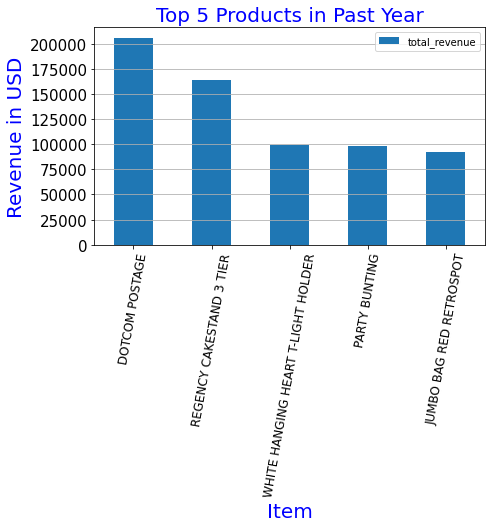

In [21]:
top_5.plot(figsize=(7,4), x ='description', y = 'total_revenue', kind = 'bar')
plt.title('Top 5 Products in Past Year', size = 20, color = 'blue')
plt.yticks(size =15)
plt.xticks(size = 12, rotation = 80)
plt.ylabel('Revenue in USD', size=20, color = 'blue')
plt.xlabel('Item', size=20, color = 'blue')
plt.grid(axis = 'y')
plt.show()
    

## Our top 5 items by total revenue are above or order by total_revenue

# Is there any seasonality to our top 5 products with the most revenue?


In [22]:
# creating a dataframe to group item description year and month, then sum the total revenue for each item, each month

# I will filter through this dataframe in cells to come

description_by_month = df.groupby(['description','year','month'])['total_revenue'].sum().reset_index()
description_by_month.head()

,description,year,month,total_revenue
0,20713,2011,October,0.00
1,4 PURPLE FLOCK DINNER CANDLES,2010,December,45.82
2,4 PURPLE FLOCK DINNER CANDLES,2011,April,17.85
3,4 PURPLE FLOCK DINNER CANDLES,2011,August,2.55
4,4 PURPLE FLOCK DINNER CANDLES,2011,December,38.71


In [23]:
# creating a list out of the description column from the top_5 dataframe created above:

top_5_list = top_5.description.to_list()
top_5_list


# using the top_5_list to filter through the description_by_month data frame and only select items described in
# the top_5_list

top_5_monthly = description_by_month.loc[description_by_month['description'].isin(top_5_list)]
top_5_monthly.head()

,description,year,month,total_revenue
9183,DOTCOM POSTAGE,2010,December,24671.19
9184,DOTCOM POSTAGE,2011,April,7535.38
9185,DOTCOM POSTAGE,2011,August,13400.52
9186,DOTCOM POSTAGE,2011,December,19872.69
9187,DOTCOM POSTAGE,2011,February,10060.57


In [24]:
# reorganizing dataframe to prep for a correctly ordered plot

# creating a list of months in order to categorize the 'month' column. Makes for easy sorting based on the order
# in the months variable below

months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

# applying previously created months variable to act as a category for the month column in the
# top_5_monthly dataframe

top_5_monthly['month'] = pd.Categorical(top_5_monthly['month'], categories=months, ordered=True)

# sorting the values by description, then, year then month, so it appears in the data
# frame and in the plot in order by year and months

top_5_monthly.sort_values(['description','year','month'], inplace = True)  

In [25]:
# joining the text from the year and month columns into a separate column called 'year_month' and separating
# the text by a comma and a space

top_5_monthly['year_month'] = top_5_monthly[['year','month']].astype(str).agg(', '.join, axis = 1)

#selecting the description, year_month and total_price columns
top_5_monthly = top_5_monthly[['description','year_month','total_revenue']].set_index('year_month')

# this dataframe is organized/clean to plot
top_5_monthly.reset_index(inplace = True)

In [26]:
top_5_monthly.head()

,year_month,description,total_revenue
0,"2010, December",DOTCOM POSTAGE,24671.19
1,"2011, January",DOTCOM POSTAGE,13918.53
2,"2011, February",DOTCOM POSTAGE,10060.57
3,"2011, March",DOTCOM POSTAGE,11829.71
4,"2011, April",DOTCOM POSTAGE,7535.38


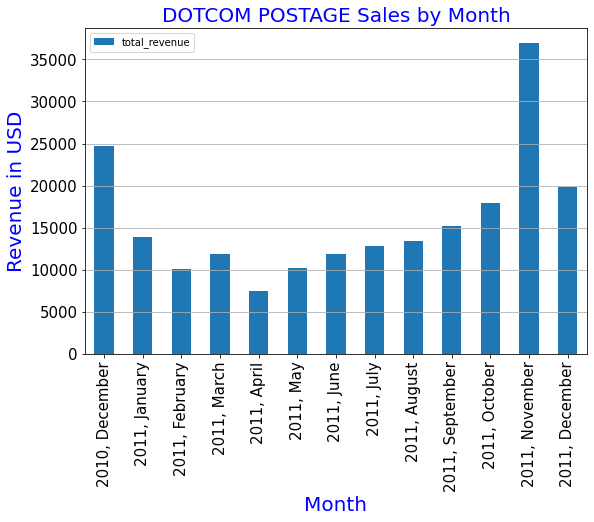

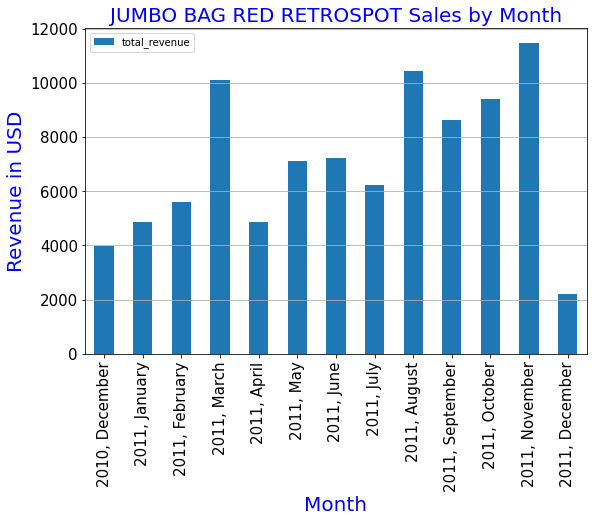

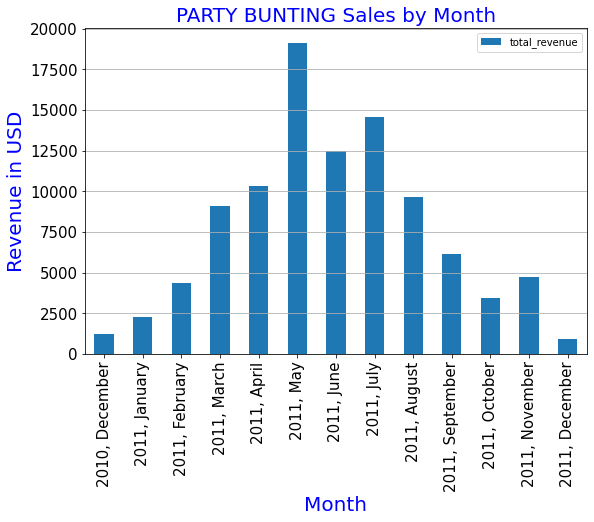

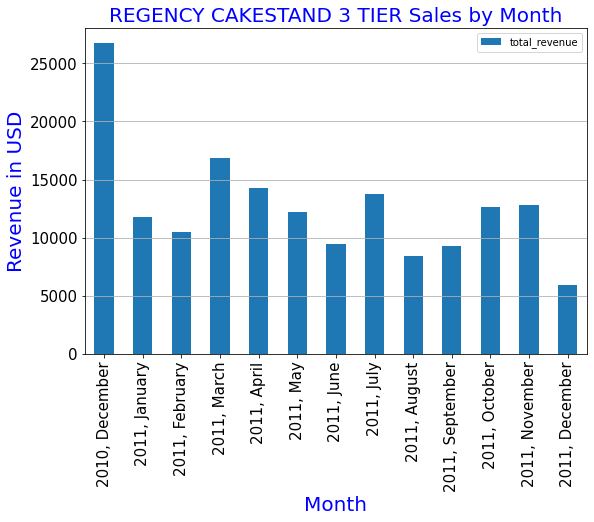

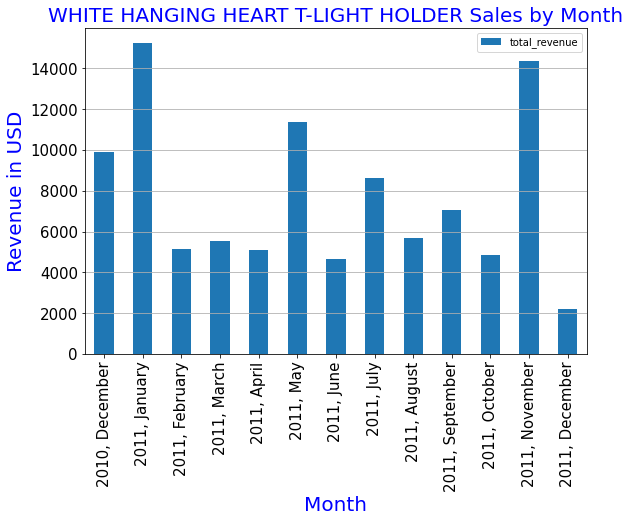

In [27]:
# identifying the unique descriptions of items and demanding them to a list for the upcoming for loop:

top_5_list = top_5_list = top_5_monthly.description.drop_duplicates().reset_index(drop = True).to_list()

# printing a bar chart for each item in the top_5_list

for i in top_5_list:
    top_5_monthly.loc[top_5_monthly['description'] == i].plot(figsize=(9,6), x ='year_month', y = 'total_revenue', kind = 'bar')
    plt.title(i+' Sales by Month', size = 20, color = 'blue')
    plt.yticks(size =15)
    plt.xticks(size = 15, rotation = 90)
    plt.ylabel('Revenue in USD', size=20, color = 'blue')
    plt.xlabel('Month',size=20, color = 'blue')
    plt.grid(axis = 'y')
    plt.show()
    

## Top 5 Products Seasonality Analysis:

Our DOTCOM POSTAGE item has trended upwards from June to November. December 2011's data is cut off, since the dataset ends at 12/9. Going forward, we could strategize to market more and more, as we move from June to December, with the most marketing in November/December.

Our JUMBO BAG RED RETROSPOT trended upward from August to November, and had a spike in March. This item appears to fall short in december 2011, but the dataset ends on December 9th. We could give this item extra attention to find out what is driving sales, and exploit the sales drivers

Our PARTY BUNTING item had an uptick in sales between March and August, and hit it's peak in May. This could be because most parties are held during this time (March - August). Maybe we could do better by intentially putting this item in front of the partiers during the warmer months in the year. 

Our REGENCY CAKESTAND 3 Tier seems to have a steady pace throughout the year, and upticks in Decemeber. The data for December 2011 falls short because the data ends on December 9th. This item appears to be the most consistent item in our top 5

Our WHITE HANGING HEART T-LIGHT HOLDER sales appear have higher revenue in the winter months. There was an uptick in sales in May 2011. We could market more prior to and during the winter season, and investigate further to understand why sales had a boost in May 2011.

# What is the best month for sales?

In [28]:
# grouping data by year and month, then summing price

monthly_sales = df.groupby(['year','month'])['total_revenue'].sum().reset_index()
monthly_sales.head()

,year,month,total_revenue
0,2010,December,746723.610
1,2011,April,492367.841
2,2011,August,681386.460
3,2011,December,432701.060
4,2011,February,497026.410


In [29]:
# restructuring dataframe to prep for a correctly ordered bar plot

# creating a list of months in order to categorize the 'month' column. Makes for easy sorting based on the order
# below

months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

# applying the above created months variable to act as a category for the month column in the
# monthly_sales dataframe

monthly_sales['month'] = pd.Categorical(monthly_sales['month'], categories=months, ordered=True)

# sorting the values by year and month, so it appears in the data frame and in the plot in order by year and months

monthly_sales.sort_values(['year','month'], inplace = True)  

In [30]:
# joining the text from the year and month columns into a separate column called 'year_month' and separating
# the text by a comma and a space

monthly_sales['year_month'] = monthly_sales[['year','month']].astype(str).agg(', '.join, axis = 1)

#selecting the year_month and total_price columns
monthly_sales = monthly_sales[['year_month','total_revenue']].set_index('year_month')

# this dataframe is organized/clean to plot
monthly_sales

,total_revenue
year_month,
"2010, December",746723.610
"2011, January",558448.560
"2011, February",497026.410
"2011, March",682013.980
"2011, April",492367.841
"2011, May",722094.100
"2011, June",689977.230
"2011, July",680156.991
"2011, August",681386.460


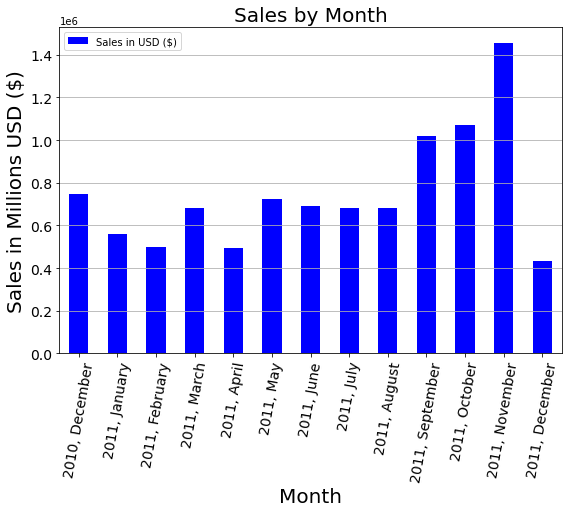

In [31]:
# Plotting sales by month

monthly_sales.plot(figsize = (9,6), kind = 'bar', color = 'blue')

plt.title('Sales by Month', size = 20)
plt.xlabel('Month', size = 20)
plt.ylabel('Sales in Millions USD ($)', size = 20)
plt.xticks(size = 14, rotation = 80)
plt.yticks(size = 14)
plt.legend(['Sales in USD ($)'])
plt.grid(axis = 'y')
    
plt.show()

### The best month for sales in this dataset was November 2011. December 2011 could have had a considerable run if the dataset didnt cut off on December 9th.

# What is the best day for sales?

In [32]:
sales_by_day = df.groupby('day')['total_revenue'].sum().reset_index()

sales_by_day

,day,total_revenue
0,Friday,1537958.621
1,Monday,1584895.301
2,Sunday,798659.461
3,Thursday,2108701.530
4,Tuesday,1965703.611
5,Wednesday,1730088.430


In [33]:
# restructuring dataframe to prep for a correctly ordered line plot

# creating a list of days in order to categorize the 'day' column. Makes for easy sorting based on the order
# below

days = ['Sunday','Monday','Tuesday', 'Wednesday', 'Thursday','Friday']

# applying previously created days variable to act as a category for the day column in the
# sales_by_day dataframe

sales_by_day['day'] = pd.Categorical(sales_by_day['day'], categories=days, ordered=True)

# sorting the values by the day, , so it appears in the data frame and in the plot in order by day

sales_by_day.sort_values(['day'], inplace = True)  
sales_by_day

,day,total_revenue
2,Sunday,798659.461
1,Monday,1584895.301
4,Tuesday,1965703.611
5,Wednesday,1730088.430
3,Thursday,2108701.530
0,Friday,1537958.621


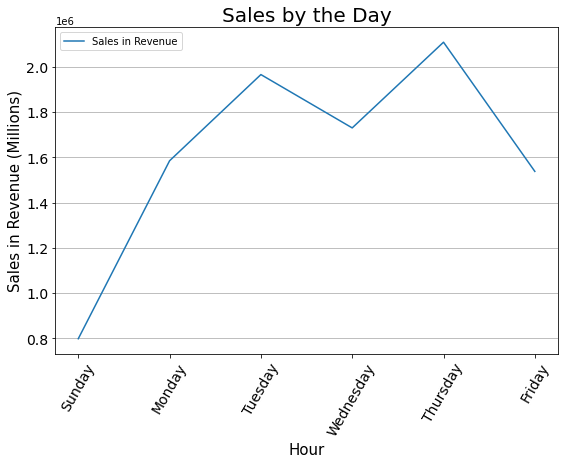

In [34]:
# plotting sales by day

plt.figure(figsize=(9,6))
plt.plot(sales_by_day.day, sales_by_day.total_revenue)
plt.xticks(days)

plt.title('Sales by the Day', size = 20)
plt.legend(['Sales in Revenue'])
plt.xlabel('Hour', size = 15)
plt.ylabel('Sales in Revenue (Millions)', size = 15)
plt.xticks(size = 14, rotation = 60)
plt.yticks(size = 14)

plt.grid(axis = 'y')
plt.show()

### We experience most of our sales during the weekday. Appearantly, we dont get any sales at all on Saturdays, and the least amount of sales on Sundays. We could do better by exploiting the marketing trends we use mid week, and applying the same methods to the weekend, may it be based on online traffic, location, or demographic. A lot of people don't work weekends, and have their hands free to shop, so this could be a lucrative marketing venture.

# What are our best hours for sales?

In [35]:
# creating a dataframe consisting of 'day' and 'total_revnue'

hourly_sales = df[['hour','total_revenue']]

In [36]:
hourly_sales.head()

,hour,total_revenue
0,8,15.30
1,8,20.34
2,8,22.00
3,8,20.34
4,8,20.34


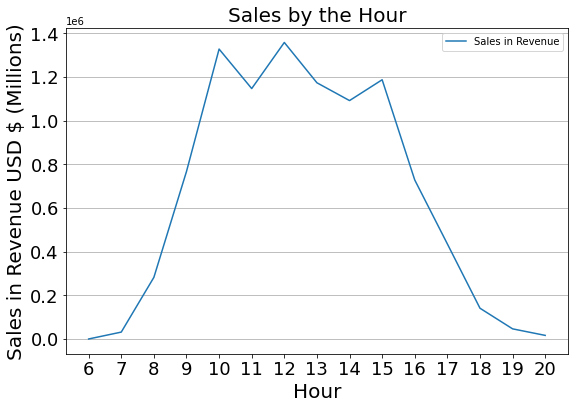

In [37]:
hours = [hour for hour, df in df.groupby('hour')]

plt.figure(figsize = (9,6))
plt.plot(hours, df.groupby('hour')['total_revenue'].sum())
plt.xticks(hours)
plt.title('Sales by the Hour', size = 20)
plt.legend(['Sales in Revenue'])
plt.xlabel('Hour', size = 20)
plt.ylabel('Sales in Revenue USD $ (Millions)', size = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.grid(axis = 'y')
plt.show()

## Most of our sales take place between 9AM and 4PM. I assume that this is dominated by revenue from the United Kingdom. We could investgate further to identify trends for countries with alternate time zones. It's interesting that most of our revenue is generated not only during the weekday, but also during work hours. Our customers are likely to be shopping at work. This information may be used to assume that our customers are employed, and further, to assume that there may be a correlation between the amount of revenue generated from our customers (Countries) and their national gdp/income levels.

# What are the best hours for sales for each day?

In [38]:
day_by_hour = df.groupby(['day', 'hour']).sum()['total_revenue'].to_frame().reset_index()
day_by_hour.head()

,day,hour,total_revenue
0,Friday,7,17234.990
1,Friday,8,52535.930
2,Friday,9,155935.531
3,Friday,10,218800.930
4,Friday,11,204190.530


In [39]:
# restructuring dataframe to prep for a correctly ordered line plot

# creating a list of days in order to categorize the 'day' column. Makes for easy sorting based on the order
# below

days = ['Sunday','Monday','Tuesday', 'Wednesday', 'Thursday','Friday']

# applying previously created days variable to act as a category for the day column in the
# day_by_hour dataframe

day_by_hour['day'] = pd.Categorical(day_by_hour['day'], categories=days, ordered=True)

# sorting the values by the day, , so it appears in the data frame and in the plot in order by day

day_by_hour.sort_values(['day','hour'], inplace = True)  
day_by_hour.head()

,day,hour,total_revenue
26,Sunday,9,749.65
27,Sunday,10,79640.27
28,Sunday,11,146619.90
29,Sunday,12,150868.99
30,Sunday,13,145422.66


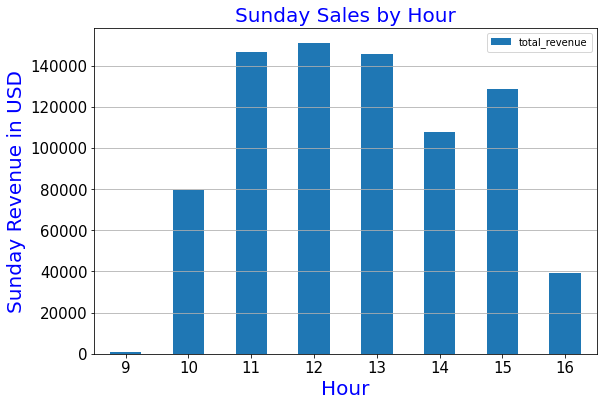

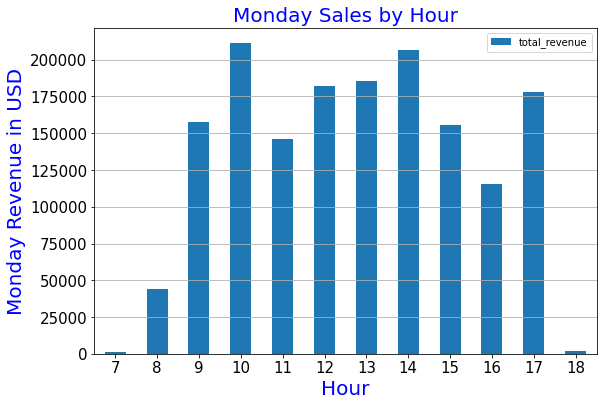

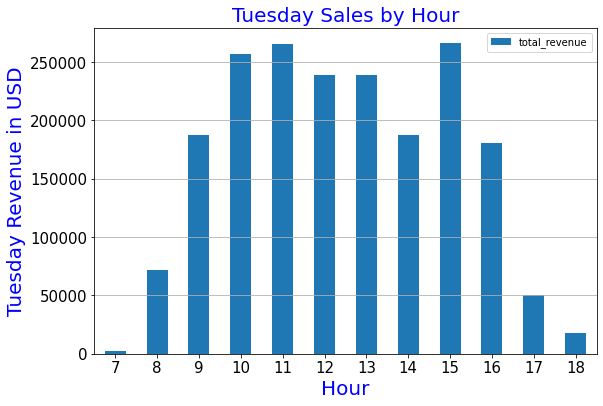

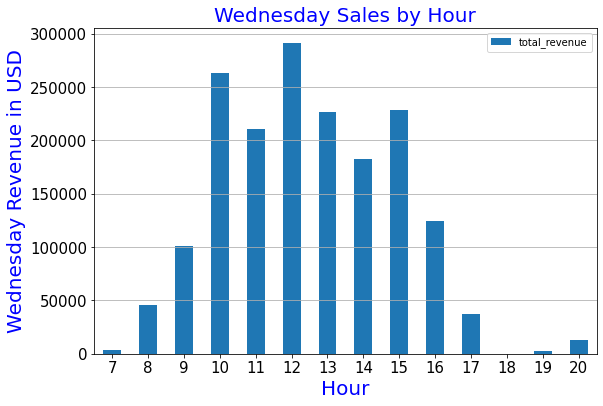

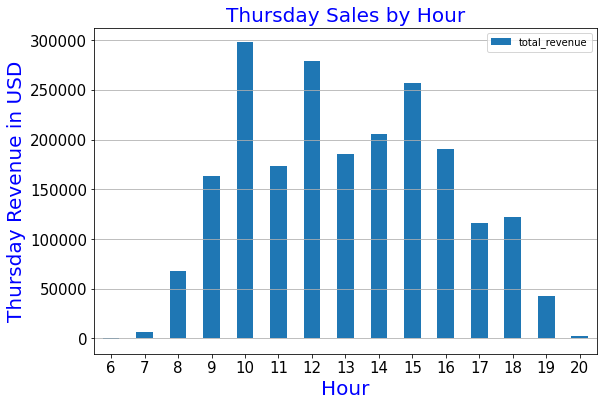

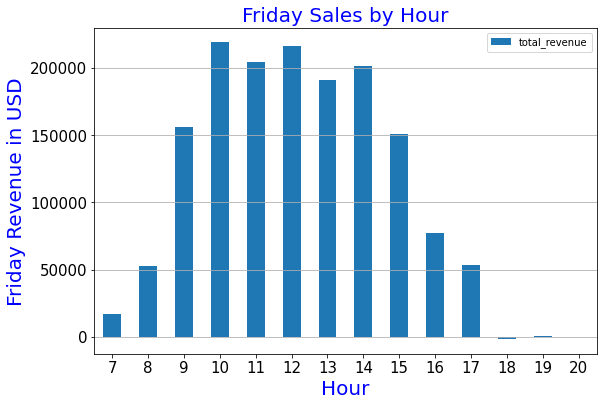

In [40]:
# identifying the unique days and demanding them to a list for the upcoming for loop:

day_by_hour_list = day_by_hour.day.drop_duplicates().reset_index(drop = True).to_list()

# printing bar chart for each day in day_by_hour_list

for i in day_by_hour_list:
    day_by_hour.loc[day_by_hour['day'] == i].plot(figsize=(9,6), x ='hour',y = 'total_revenue', kind ='bar')
    plt.title(i+' Sales by Hour', size = 20, color = 'blue')
    plt.yticks(size =15)
    plt.xticks(size = 15, rotation = 0)
    plt.ylabel(i +' Revenue in USD', size=20, color = 'blue')
    plt.xlabel('Hour',size=20, color = 'blue')
    plt.grid(axis = 'y')
    plt.show()

## Where are most of our customers?

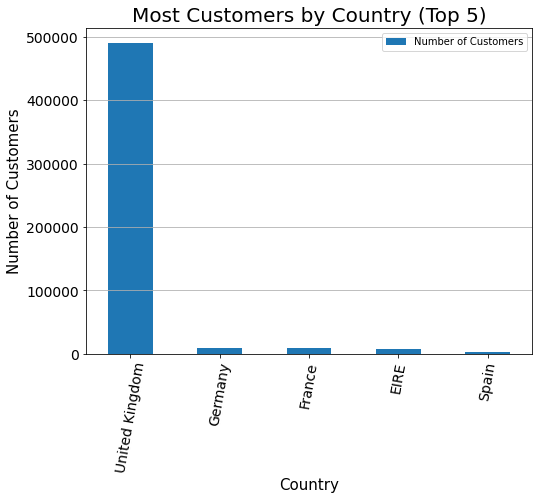

In [41]:
# Countries with more number of customers

cus_id = pd.DataFrame(df.groupby('country')['customerid'].count().sort_values(ascending = False))

cus_id[:5].plot(figsize = (8,6), kind = 'bar')
plt.title('Most Customers by Country (Top 5)', size = 20)
plt.legend(['Number of Customers'])
plt.xlabel('Country', size = 15)
plt.ylabel('Number of Customers', size = 15)
plt.xticks(size = 14, rotation = 80)
plt.yticks(size = 14)

plt.grid(axis = 'y')
plt.show()

## What countries contain the least of our customers?

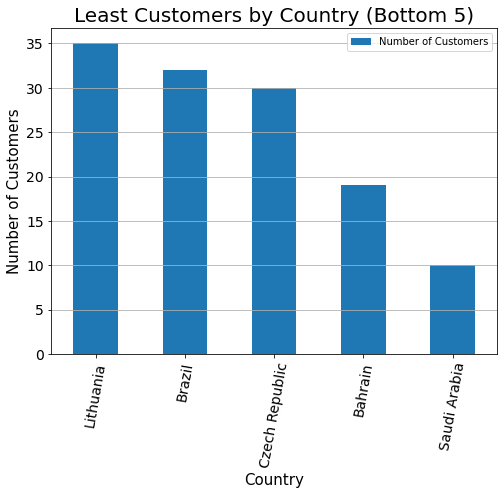

In [42]:
# Countries with least number of customers

cus_id[-5:].plot(figsize = (8,6), kind = 'bar', title = 'Least customers for country')

plt.title('Least Customers by Country (Bottom 5)', size = 20)
plt.legend(['Number of Customers'])
plt.xlabel('Country', size = 15)
plt.ylabel('Number of Customers', size = 15)
plt.xticks(size = 14, rotation = 80)
plt.yticks(size = 14)

plt.grid(axis = 'y')
plt.show()

# What are our top 5 countries by sales dollars? 

In [43]:
# Grouping countries by total_Amount of sales

country_price = df.groupby('country')['total_revenue'].sum().sort_values(ascending = False)
country_price[:5]

country
United Kingdom    8167128.184
Netherlands        284661.540
EIRE               262993.380
Germany            221509.470
France             197317.110
Name: total_revenue, dtype: float64

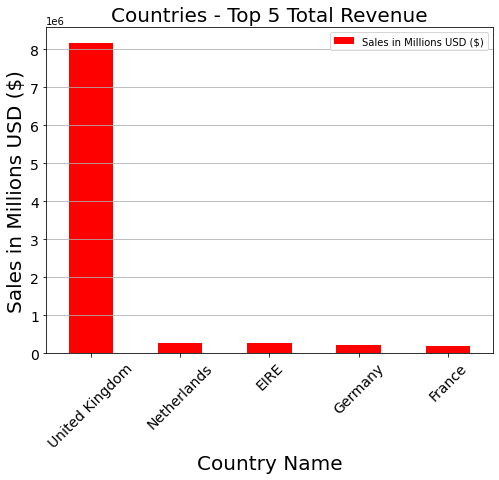

In [44]:
# Plotting the countries in our top 5 in Sales

country_price[:5].plot(figsize = (8,6),
                       kind = 'bar',
                      color = 'red')
plt.title('Countries - Top 5 Total Revenue', size = 20)
plt.ylabel('Sales in Millions USD ($)', size = 20)
plt.xlabel('Country Name', size = 20)
plt.xticks(size = 14, rotation = 45)
plt.yticks(size = 14)
plt.legend(['Sales in Millions USD ($)'])
plt.grid(axis ='y')
plt.show()

## We are exposed mostly to the United Kindom. We could do well by marketing to other countries with a similar demographic as that in the United Kingdom. We can see more clearly in the plot below, that the top 5 countries just below the United Kingdom (which holds the number 1 spot in our total revenue rankings) all have made more than 100,000 USD in purchases. We could aim to increase those numbers

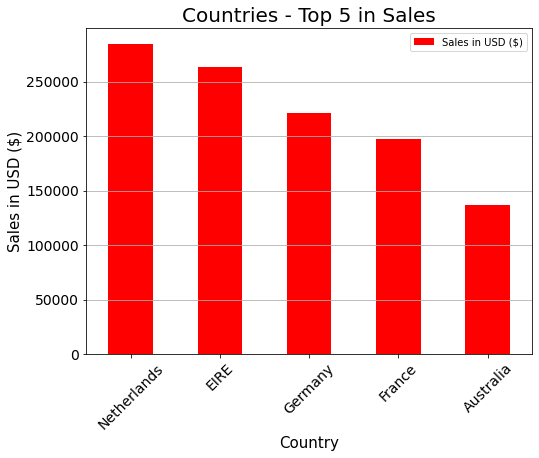

In [45]:
plt.figure(figsize=(8,6))

country_price[1:6].plot(kind = 'bar',
                      color = 'red')
plt.title('Countries - Top 5 in Sales', size = 20)
plt.ylabel('Sales in USD ($)', size = 15)
plt.xlabel('Country', size = 15)
plt.xticks(size = 14, rotation = 45)
plt.yticks(size = 14)
plt.legend(['Sales in USD ($)'])
plt.grid(axis = 'y')
plt.show()

# Top 5 Countries with least number of sales in USD $

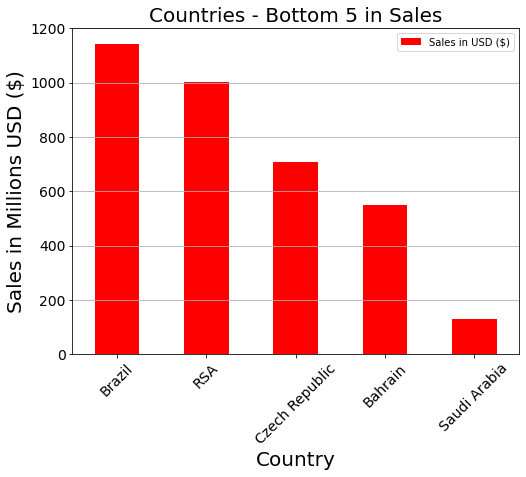

In [46]:
# Plotting the countries in our bottom 5 in Sales

country_price[33:].plot(figsize = (8,6),
                        kind = 'bar',
                      color = 'red')

plt.title('Countries - Bottom 5 in Sales', size = 20)
plt.ylabel('Sales in Millions USD ($)', size = 20)
plt.xlabel('Country', size = 20)
plt.xticks(size = 14, rotation = 45)
plt.yticks(size = 14)
plt.legend(['Sales in USD ($)'])

plt.grid(axis = 'y')

plt.show()

## For these customers (countries), we could weigh the cost of marketing versus ROI. We might be better off not increasing marketing attempts to demand more dollars from these countries, and target countries with more buying power, and interest in our products. On the other hand, we can investigate further to determine why these countries are so low in sales, and try to mitigate those obstacles.